# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band10.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.924686  ...  -1.0 -0.568063 -0.716146  -1.0  -1.0 -0.501817   
      201547 -0.924686  ...  -1.0 -0.568063 -0.716146  -1.0  -1.0 -0.501817   
      201548 -0.924686  ...  -1.0 -0.568063 -0.716146  -1.0  -1.0 -0.501817   
      201549 -0.924686  ...  -1.0 -0.568063 -0.716146  -1.0  -1.0 -0.501817   
      201550 -0.924686  ...  -1.0 -0.568063 -0.716146  -1.0  -1.0 -0.501817   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.869743  -1.0 -0.861740  
      201547  -1.0 -0.869743  -1.0 -0.854589  
      201548  -1.0 -0.869743  -1.0 -0.856973  
      201549  -1.0 -0.869743  -1.0 -0.856973  
      201550  -1.0 -0.869743  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0    1         2         3         4    5    6    7         8  \
41001 201820 -1.0 -1.0 -0.993193  0.587210 -0.905442 -1.0 -1.0 -1.0 -0.993406   
      201821 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.000000   
      201822 -1.0 -1.0 -0.962535  0.182849 -0.928822 -1.0 -1.0 -1.0 -1.000000   
      201823 -1.0 -1.0 -0.984631 -0.926618 -1.000000 -1.0 -1.0 -1.0 -1.000000   
      201824 -1.0 -1.0 -0.963056 -0.007712 -1.000000 -1.0 -1.0 -1.0 -1.000000   

                     9  ...      2039      2040      2041  2042      2043  \
41001 201820 -0.921953  ... -1.000000 -0.361745 -0.684834  -1.0 -1.000000   
      201821 -0.924686  ... -1.000000 -0.568063 -0.716146  -1.0 -1.000000   
      201822 -0.924686  ... -1.000000 -0.568063 -0.716146  -1.0 -1.000000   
      201823 -0.981490  ... -1.000000 -0.635595 -1.000000  -1.0 -0.809773   
      201824 -0.973613  ... -0.354172 -0.377568 -1.000000  -1.0 -1.000000   

                  2044  2045      2046      2047    Labels  
41001 201820 -0.507467  -1.0 -0.752551 -1.000000 -0.949940  
      201821 -0.501817  -1.0 -0.869743 -1.000000 -0.961859  
      201822 -0.501817  -1.0 -0.869743 -1.000000 -0.940405  
      201823 -0.938709  -1.0 -0.380446  0.334564 -0.961859  
      201824 -0.759226  -1.0 -0.830334 -0.722284 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

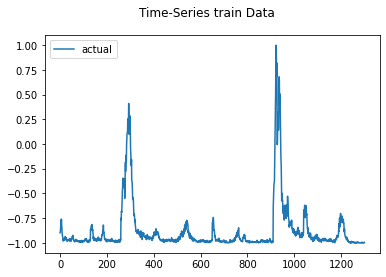

2023-03-07 14:51:04.265718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:51:04.265779: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:51:04.265846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 14:51:04.266361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:51:04.766183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 398.545
Test RMSE: 546.671
Test sMAPE: 147.539
Test R Squared: -308.239
{'mae': 398.5448828032522, 'rmse': 546.6711966996423, 'smape': 147.53919761179034, 'r2': -308.23908955865267}


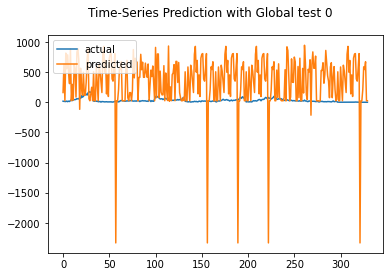

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 201.415
Test RMSE: 264.443
Test sMAPE: 196.537
Test R Squared: -71.361
{'mae': 201.41452040961295, 'rmse': 264.4432455153936, 'smape': 196.53679970780792, 'r2': -71.36139970050357}


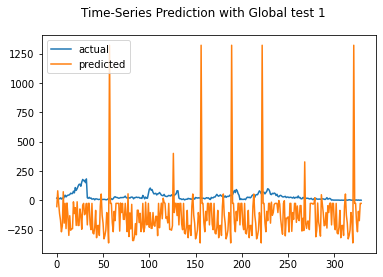

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 145.887
Test RMSE: 179.948
Test sMAPE: 180.444
Test R Squared: -32.507
{'mae': 145.88683492125887, 'rmse': 179.94799243058023, 'smape': 180.44375717063204, 'r2': -32.507036086171986}


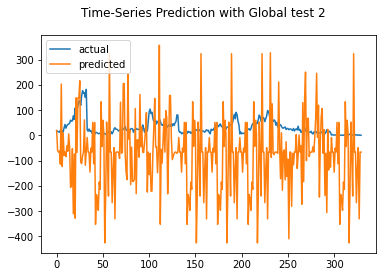

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 59.467
Test RMSE: 106.199
Test sMAPE: 111.814
Test R Squared: -10.670
{'mae': 59.46731412771976, 'rmse': 106.19856856714442, 'smape': 111.81447727663213, 'r2': -10.670227644602017}


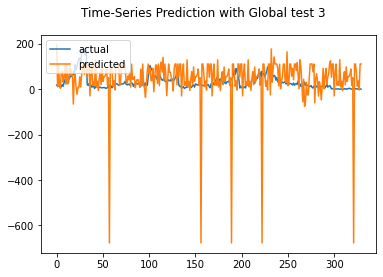

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 67.501
Test RMSE: 136.094
Test sMAPE: 115.611
Test R Squared: -18.165
{'mae': 67.5006318988222, 'rmse': 136.0935385152142, 'smape': 115.61089583748132, 'r2': -18.165361436342305}


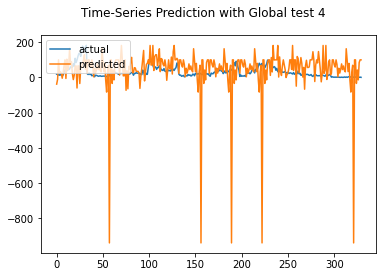

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 89.594
Test RMSE: 125.605
Test sMAPE: 146.056
Test R Squared: -15.325
{'mae': 89.59413168376142, 'rmse': 125.60494681836971, 'smape': 146.05620020672742, 'r2': -15.325086443507079}


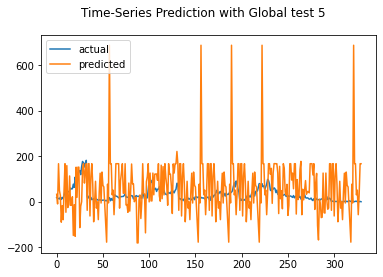

Test MAE: 123.593
Test RMSE: 676.854
Test sMAPE: 116.631
Test R Squared: -473.058
{'mae': 123.59267005270178, 'rmse': 676.8535521365371, 'smape': 116.63063848671209, 'r2': -473.0579417093557}


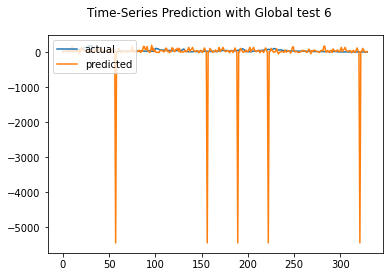

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 45.405
Test RMSE: 54.466
Test sMAPE: 111.302
Test R Squared: -2.070
{'mae': 45.40519466833635, 'rmse': 54.46560919836836, 'smape': 111.30185499212662, 'r2': -2.069634963134343}


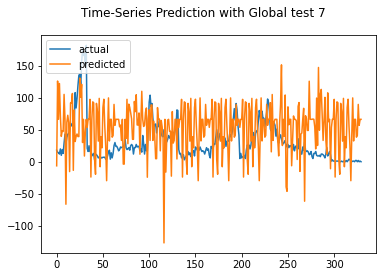

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 50.341
Test RMSE: 70.133
Test sMAPE: 118.244
Test R Squared: -4.090
{'mae': 50.340712516958064, 'rmse': 70.13266744225987, 'smape': 118.24383402432635, 'r2': -4.089589035987186}


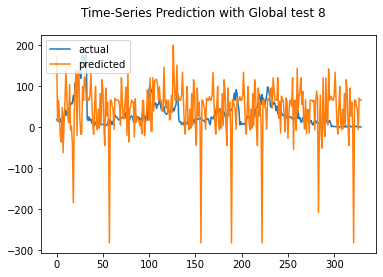

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 78.525
Test RMSE: 140.440
Test sMAPE: 114.121
Test R Squared: -19.409
{'mae': 78.52548975438782, 'rmse': 140.43995767954726, 'smape': 114.12124209744078, 'r2': -19.40907781323913}


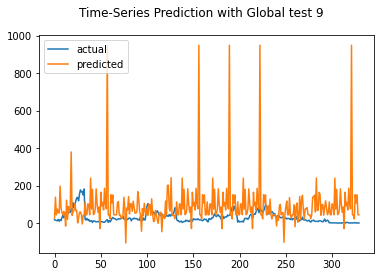

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 46.264
Test RMSE: 89.906
Test sMAPE: 109.358
Test R Squared: -7.364
{'mae': 46.263658262744094, 'rmse': 89.90618553340202, 'smape': 109.35813962015932, 'r2': -7.364137159444706}


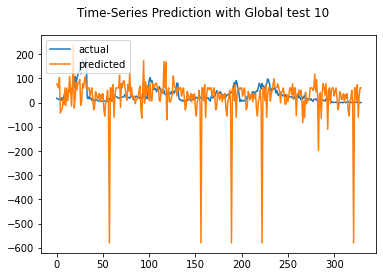

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 81.887
Test RMSE: 123.673
Test sMAPE: 150.097
Test R Squared: -14.827
{'mae': 81.88729105447278, 'rmse': 123.6733506806936, 'smape': 150.09722324826623, 'r2': -14.826841614745522}


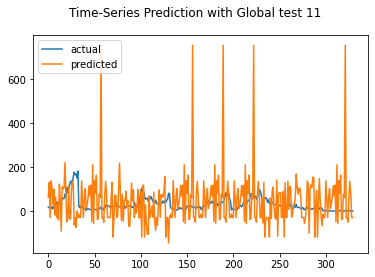

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 138.061
Test RMSE: 279.616
Test sMAPE: 161.541
Test R Squared: -79.903
{'mae': 138.0610348907384, 'rmse': 279.6158775782791, 'smape': 161.54065900847536, 'r2': -79.90319235684815}


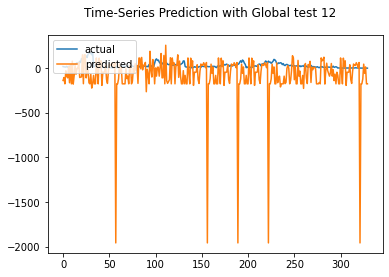

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 219.989
Test RMSE: 351.317
Test sMAPE: 157.460
Test R Squared: -126.714
{'mae': 219.9890595244639, 'rmse': 351.31660485419417, 'smape': 157.46020499066805, 'r2': -126.71424953877788}


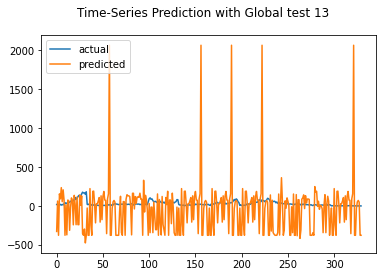

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 69.466
Test RMSE: 116.436
Test sMAPE: 118.330
Test R Squared: -13.029
{'mae': 69.46617689981605, 'rmse': 116.43556162644512, 'smape': 118.32988704228954, 'r2': -13.028566213868178}


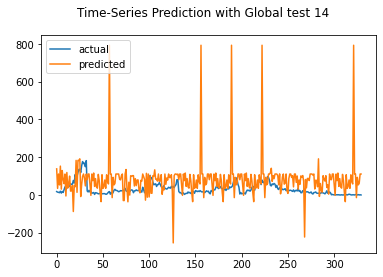

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 113.219
Test RMSE: 251.797
Test sMAPE: 155.206
Test R Squared: -64.606
{'mae': 113.21932831822019, 'rmse': 251.7973922571842, 'smape': 155.2055781268318, 'r2': -64.60613566812134}


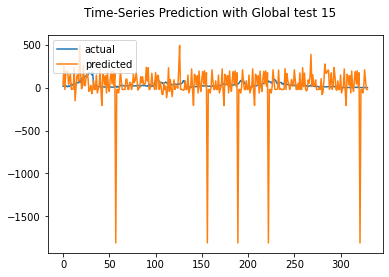

Test MAE: 77.045
Test RMSE: 110.509
Test sMAPE: 132.427
Test R Squared: -11.637
{'mae': 77.04496094467062, 'rmse': 110.5091333265175, 'smape': 132.4270875625392, 'r2': -11.636835949861759}


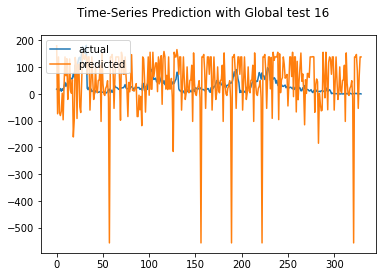

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 63.450
Test RMSE: 113.221
Test sMAPE: 104.655
Test R Squared: -12.265
{'mae': 63.44991656288956, 'rmse': 113.22099239232116, 'smape': 104.65504940111013, 'r2': -12.26465369100091}


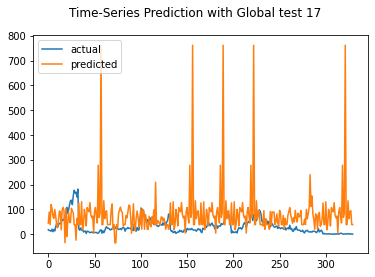

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 123.580
Test RMSE: 204.700
Test sMAPE: 154.973
Test R Squared: -42.359
{'mae': 123.58048853657462, 'rmse': 204.69989260458735, 'smape': 154.97272543955285, 'r2': -42.35879771787037}


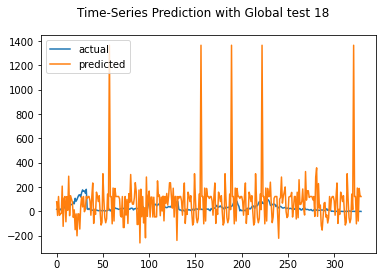

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 109.121
Test RMSE: 188.141
Test sMAPE: 143.228
Test R Squared: -35.628
{'mae': 109.12056177366864, 'rmse': 188.1407808207969, 'smape': 143.22785333879773, 'r2': -35.62755134811538}


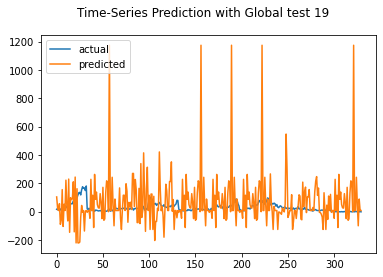

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 157.491
Test RMSE: 211.321
Test sMAPE: 140.212
Test R Squared: -45.209
{'mae': 157.4912219394337, 'rmse': 211.32079085254472, 'smape': 140.21164281170363, 'r2': -45.208987890864016}


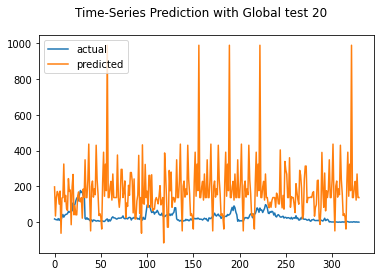

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 91.795
Test RMSE: 169.291
Test sMAPE: 152.521
Test R Squared: -28.656
{'mae': 91.79461458921432, 'rmse': 169.29054928650564, 'smape': 152.52060345470025, 'r2': -28.65564880195039}


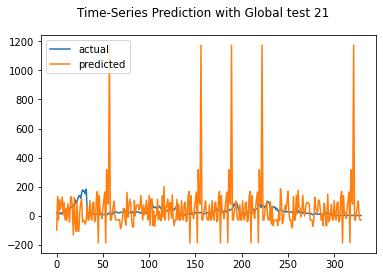

Test MAE: 85.883
Test RMSE: 309.603
Test sMAPE: 102.937
Test R Squared: -98.187
{'mae': 85.88276084697608, 'rmse': 309.6032437286382, 'smape': 102.93678808113688, 'r2': -98.18660058706818}


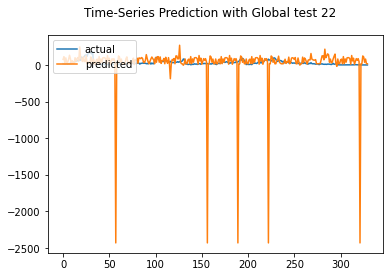

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 359.178
Test RMSE: 398.046
Test sMAPE: 165.621
Test R Squared: -162.949
{'mae': 359.17761444034, 'rmse': 398.0458012044461, 'smape': 165.62145405020163, 'r2': -162.9487447449103}


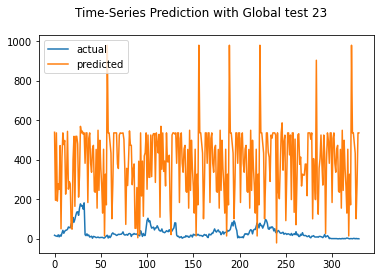

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 110.386
Test RMSE: 134.626
Test sMAPE: 189.411
Test R Squared: -17.754
{'mae': 110.38588327828681, 'rmse': 134.6263553681828, 'smape': 189.4114896935831, 'r2': -17.754357006685943}


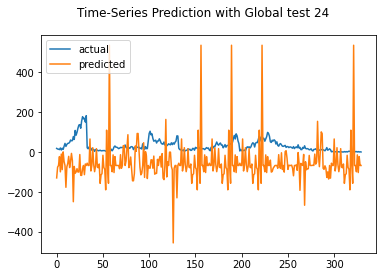

Test MAE: 67.325
Test RMSE: 82.692
Test sMAPE: 117.959
Test R Squared: -6.076
{'mae': 67.32539876699448, 'rmse': 82.69230693575659, 'smape': 117.95872348061147, 'r2': -6.075745724294839}


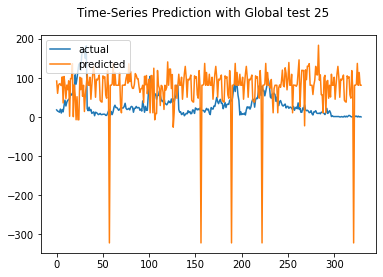

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 62.832
Test RMSE: 121.203
Test sMAPE: 111.785
Test R Squared: -14.201
{'mae': 62.832330665805124, 'rmse': 121.20266553685452, 'smape': 111.78528633533014, 'r2': -14.200796462725242}


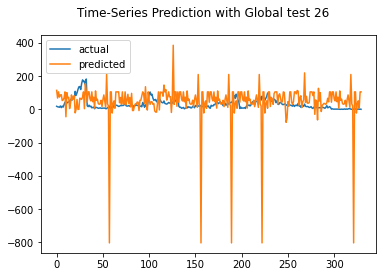

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 32.546
Test RMSE: 45.932
Test sMAPE: 112.799
Test R Squared: -1.183
{'mae': 32.545764751235644, 'rmse': 45.93237830422924, 'smape': 112.79923803246801, 'r2': -1.1831313580137959}


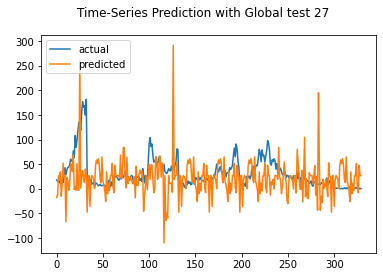

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 52.395
Test RMSE: 68.057
Test sMAPE: 105.737
Test R Squared: -3.793
{'mae': 52.39503645282803, 'rmse': 68.0570488588914, 'smape': 105.73735224746362, 'r2': -3.7927880924400217}


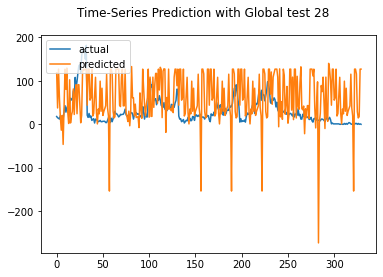

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 216.031
Test RMSE: 445.137
Test sMAPE: 174.555
Test R Squared: -204.035
{'mae': 216.0307526123343, 'rmse': 445.1367564756226, 'smape': 174.555081522876, 'r2': -204.03543104139717}


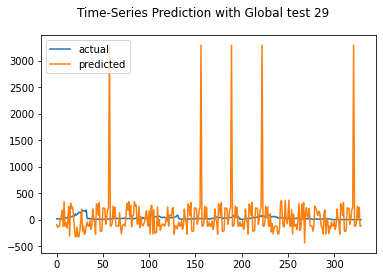

Test MAE: 335.298
Test RMSE: 1894.341
Test sMAPE: 149.031
Test R Squared: -3712.287
{'mae': 335.297987316594, 'rmse': 1894.3414197405452, 'smape': 149.0313966919375, 'r2': -3712.2869566755544}


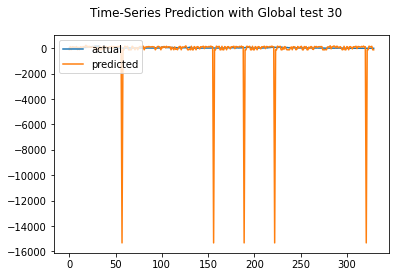

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 253.495
Test RMSE: 312.659
Test sMAPE: 150.814
Test R Squared: -100.154
{'mae': 253.49534963261, 'rmse': 312.6592265357939, 'smape': 150.81352401861722, 'r2': -100.15433516344264}


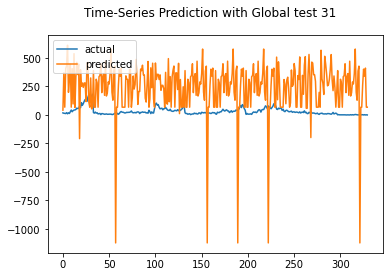

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 81.180
Test RMSE: 121.049
Test sMAPE: 133.619
Test R Squared: -14.162
{'mae': 81.18021460536754, 'rmse': 121.04851970771885, 'smape': 133.6194085137329, 'r2': -14.162156233834711}


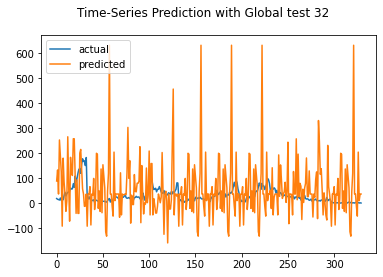

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 266.076
Test RMSE: 441.708
Test sMAPE: 179.365
Test R Squared: -200.889
{'mae': 266.076299755501, 'rmse': 441.70836809456046, 'smape': 179.3650092374824, 'r2': -200.88927832977467}


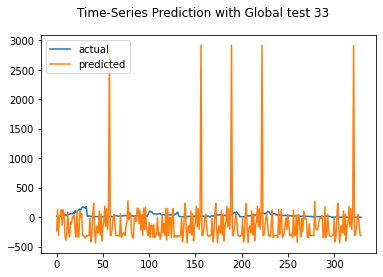

Test MAE: 121.838
Test RMSE: 167.563
Test sMAPE: 154.257
Test R Squared: -28.054
{'mae': 121.83824361598853, 'rmse': 167.56339687317575, 'smape': 154.25691787055064, 'r2': -28.05362410908999}


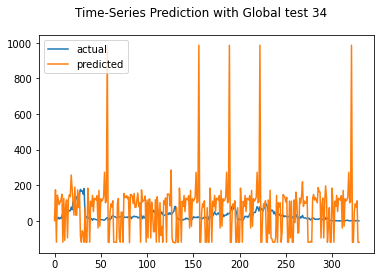

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 128.673
Test RMSE: 236.923
Test sMAPE: 165.332
Test R Squared: -57.084
{'mae': 128.67315410086604, 'rmse': 236.92279534285876, 'smape': 165.3318424204458, 'r2': -57.08389046331733}


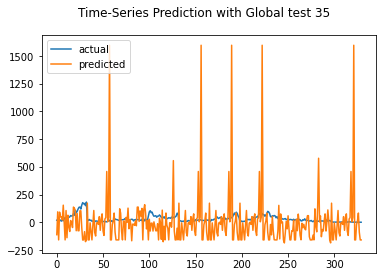

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 73.106
Test RMSE: 166.279
Test sMAPE: 116.679
Test R Squared: -27.610
{'mae': 73.10629183622923, 'rmse': 166.27895709840135, 'smape': 116.67917816687779, 'r2': -27.60991618844306}


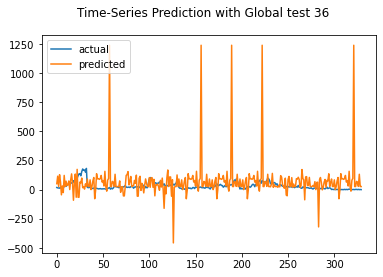

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 144.167
Test RMSE: 179.053
Test sMAPE: 139.587
Test R Squared: -32.175
{'mae': 144.16664784351985, 'rmse': 179.05333786310945, 'smape': 139.58670860284101, 'r2': -32.17468780043303}


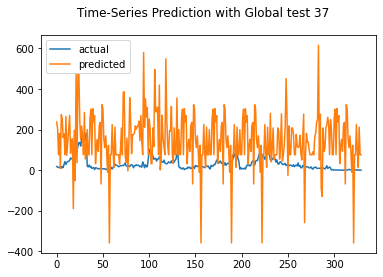

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 51.278
Test RMSE: 139.483
Test sMAPE: 114.045
Test R Squared: -19.132
{'mae': 51.27754727583943, 'rmse': 139.48284621828418, 'smape': 114.0450606988541, 'r2': -19.13184617060664}


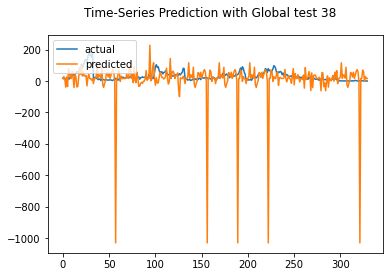

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 102.058
Test RMSE: 121.984
Test sMAPE: 152.569
Test R Squared: -14.397
{'mae': 102.0580546429663, 'rmse': 121.98421074789812, 'smape': 152.56897378719356, 'r2': -14.39746561338044}


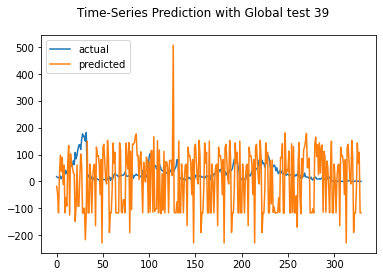

Test MAE: 49.001
Test RMSE: 103.807
Test sMAPE: 113.193
Test R Squared: -10.151
{'mae': 49.00067348823403, 'rmse': 103.80703798891042, 'smape': 113.19331926206307, 'r2': -10.15053229678688}


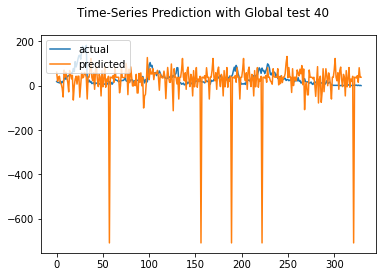

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 183.808
Test RMSE: 236.585
Test sMAPE: 158.577
Test R Squared: -56.918
{'mae': 183.8083394397389, 'rmse': 236.5850368683788, 'smape': 158.5771356145037, 'r2': -56.918399065935596}


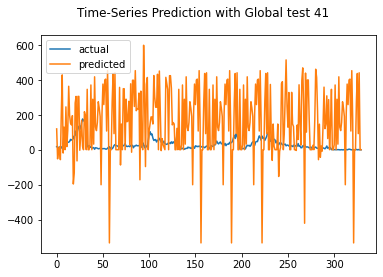

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 187.487
Test RMSE: 320.490
Test sMAPE: 187.010
Test R Squared: -105.285
{'mae': 187.48687397277718, 'rmse': 320.4902120695097, 'smape': 187.00973959624977, 'r2': -105.2848937292729}


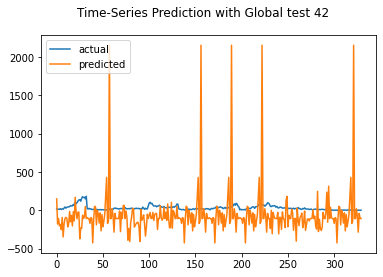

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 128.820
Test RMSE: 264.658
Test sMAPE: 134.367
Test R Squared: -71.479
{'mae': 128.82028978810166, 'rmse': 264.6579747325463, 'smape': 134.36698911022074, 'r2': -71.47896303768798}


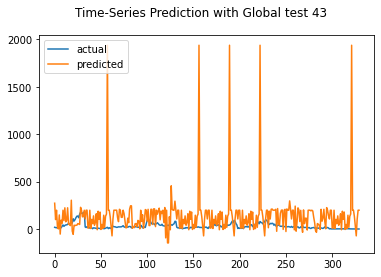

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 153.588
Test RMSE: 252.046
Test sMAPE: 174.543
Test R Squared: -64.736
{'mae': 153.5880089895292, 'rmse': 252.04585673789126, 'smape': 174.54265258220403, 'r2': -64.73567503148337}


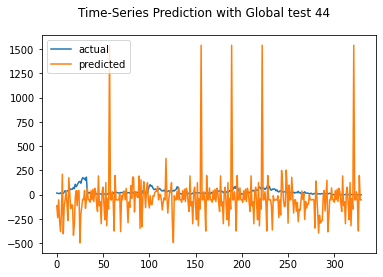

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 203.511
Test RMSE: 500.869
Test sMAPE: 151.460
Test R Squared: -258.592
{'mae': 203.51104493249545, 'rmse': 500.8693135902845, 'smape': 151.45972230757528, 'r2': -258.59172923676215}


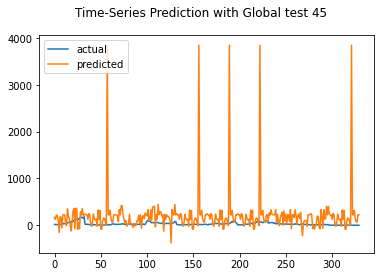

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 185.566
Test RMSE: 216.749
Test sMAPE: 184.930
Test R Squared: -47.613
{'mae': 185.5661110935789, 'rmse': 216.74888619541815, 'smape': 184.93026900982179, 'r2': -47.61337247057715}


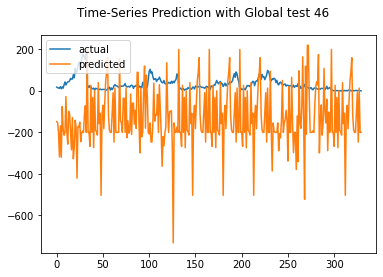

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 66.039
Test RMSE: 191.176
Test sMAPE: 124.661
Test R Squared: -36.819
{'mae': 66.03858537981004, 'rmse': 191.1756262334313, 'smape': 124.66082756865194, 'r2': -36.81873905814518}


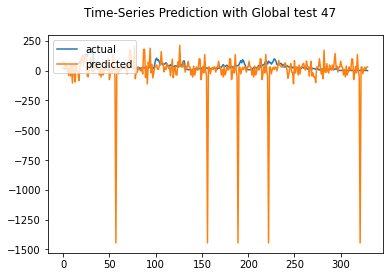

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 263.270
Test RMSE: 322.854
Test sMAPE: 185.039
Test R Squared: -106.858
{'mae': 263.27023805127, 'rmse': 322.853527738244, 'smape': 185.039301134204, 'r2': -106.85817660385055}


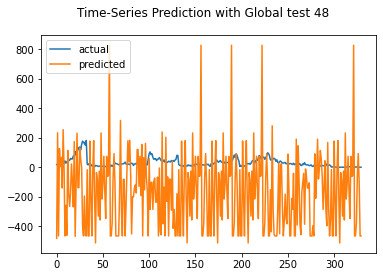

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 188.219
Test RMSE: 315.693
Test sMAPE: 186.314
Test R Squared: -102.127
{'mae': 188.21859433605815, 'rmse': 315.693019531203, 'smape': 186.31445239436985, 'r2': -102.12689923125592}


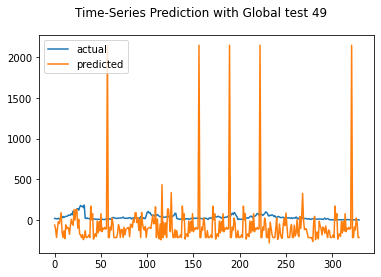

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 142.907
Test RMSE: 167.625
Test sMAPE: 161.683
Test R Squared: -28.075
{'mae': 142.9070407340021, 'rmse': 167.62519171128432, 'smape': 161.68344954346438, 'r2': -28.07505713185388}


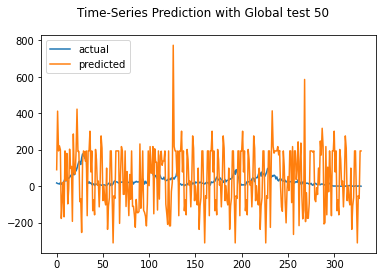

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 207.075
Test RMSE: 257.908
Test sMAPE: 166.130
Test R Squared: -67.829
{'mae': 207.0754460768266, 'rmse': 257.90791518843093, 'smape': 166.1298625016406, 'r2': -67.82898153437603}


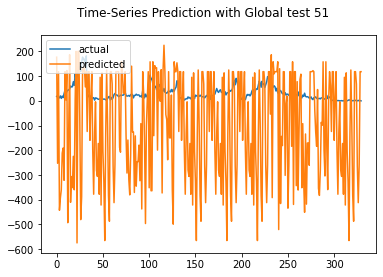

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 59.264
Test RMSE: 77.713
Test sMAPE: 112.760
Test R Squared: -5.249
{'mae': 59.2644465965755, 'rmse': 77.71284457058397, 'smape': 112.76014359684227, 'r2': -5.249245895819799}


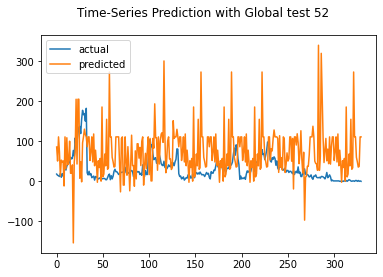

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 281.451
Test RMSE: 370.526
Test sMAPE: 173.364
Test R Squared: -141.062
{'mae': 281.45079688809136, 'rmse': 370.5259046426751, 'smape': 173.36409978747304, 'r2': -141.06240224662156}


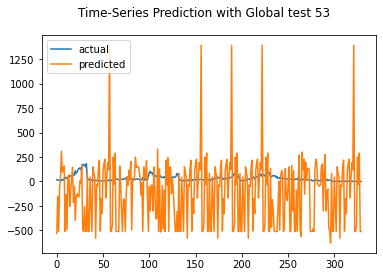

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 141.589
Test RMSE: 197.015
Test sMAPE: 167.508
Test R Squared: -39.164
{'mae': 141.58932202006832, 'rmse': 197.01464241718483, 'smape': 167.50764134063112, 'r2': -39.16418984425678}


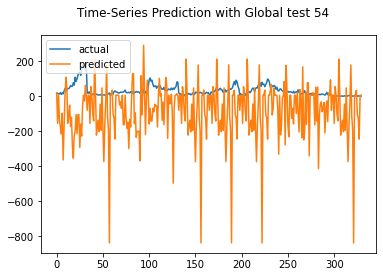

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 179.491
Test RMSE: 625.424
Test sMAPE: 180.814
Test R Squared: -403.754
{'mae': 179.4910554300655, 'rmse': 625.4243925222003, 'smape': 180.81350582577574, 'r2': -403.7544502163843}


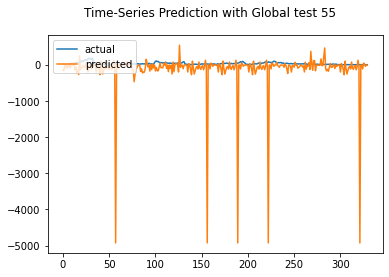

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 55.371
Test RMSE: 81.025
Test sMAPE: 124.003
Test R Squared: -5.793
{'mae': 55.37060564214533, 'rmse': 81.025020390668, 'smape': 124.00280349152092, 'r2': -5.793292268071074}


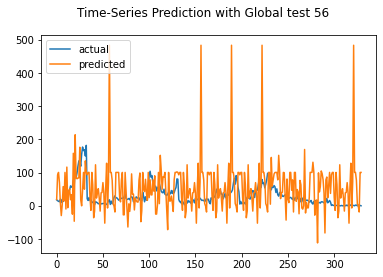

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 114.115
Test RMSE: 207.928
Test sMAPE: 162.794
Test R Squared: -43.737
{'mae': 114.11532484473604, 'rmse': 207.9278200333965, 'smape': 162.79356183407873, 'r2': -43.73703551619029}


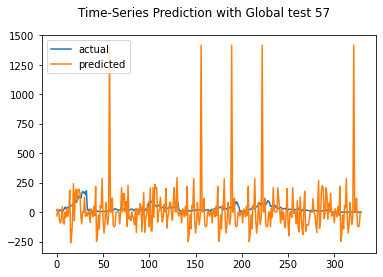

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 62.251
Test RMSE: 82.240
Test sMAPE: 116.195
Test R Squared: -5.998
{'mae': 62.2512009714589, 'rmse': 82.2396222328085, 'smape': 116.19491379565588, 'r2': -5.998487884685039}


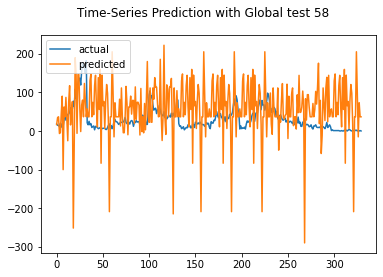

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 66.883
Test RMSE: 92.922
Test sMAPE: 164.518
Test R Squared: -7.935
{'mae': 66.88334181200375, 'rmse': 92.92194289997958, 'smape': 164.51803586504838, 'r2': -7.934671004379922}


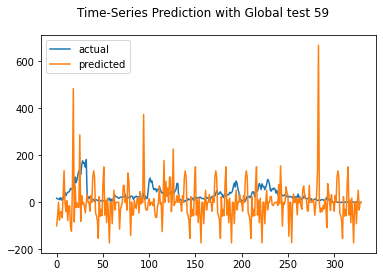

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 60.769
Test RMSE: 104.942
Test sMAPE: 118.417
Test R Squared: -10.396
{'mae': 60.769066924579214, 'rmse': 104.94245329394953, 'smape': 118.41666066297363, 'r2': -10.395789725920391}


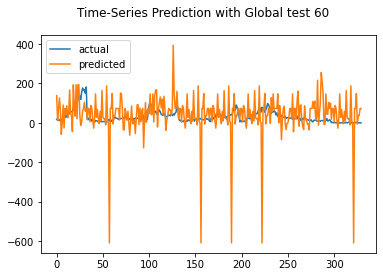

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 100.587
Test RMSE: 204.211
Test sMAPE: 151.837
Test R Squared: -42.152
{'mae': 100.58713794639617, 'rmse': 204.2113681025927, 'smape': 151.83652010815612, 'r2': -42.15208965228577}


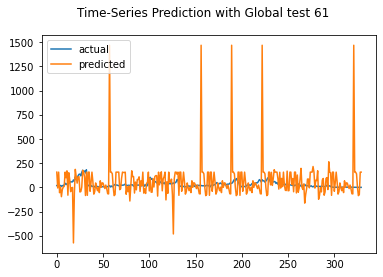

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 181.585
Test RMSE: 229.535
Test sMAPE: 175.940
Test R Squared: -53.518
{'mae': 181.58531705682927, 'rmse': 229.53528859064357, 'smape': 175.9396594592484, 'r2': -53.51812711621497}


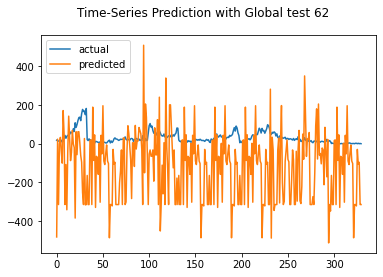

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 34.798
Test RMSE: 50.210
Test sMAPE: 99.527
Test R Squared: -1.609
{'mae': 34.79764853761051, 'rmse': 50.210042852840594, 'smape': 99.5271789557241, 'r2': -1.6086942788096046}


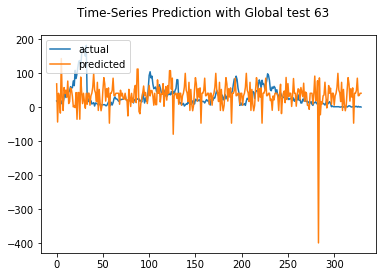

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 181.447
Test RMSE: 345.364
Test sMAPE: 183.585
Test R Squared: -122.423
{'mae': 181.44722703659173, 'rmse': 345.3635932988493, 'smape': 183.58515206279495, 'r2': -122.42271913263248}


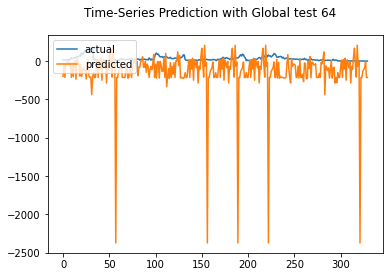

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 49.028
Test RMSE: 62.714
Test sMAPE: 113.350
Test R Squared: -3.070
{'mae': 49.02792890396985, 'rmse': 62.71447954345159, 'smape': 113.35000277661231, 'r2': -3.0698429120830335}


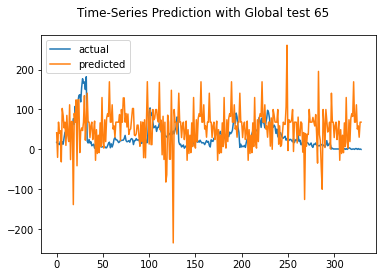

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 60.247
Test RMSE: 131.721
Test sMAPE: 122.355
Test R Squared: -16.954
{'mae': 60.24739278085304, 'rmse': 131.72122295197303, 'smape': 122.3549700766276, 'r2': -16.953681236009345}


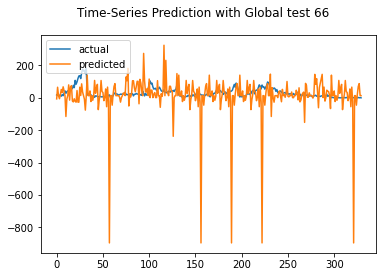

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 152.506
Test RMSE: 484.459
Test sMAPE: 146.274
Test R Squared: -241.860
{'mae': 152.50565679362325, 'rmse': 484.4586707285584, 'smape': 146.2739520618185, 'r2': -241.8597077645127}


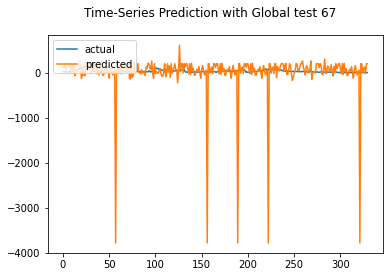

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 127.023
Test RMSE: 209.032
Test sMAPE: 162.043
Test R Squared: -44.213
{'mae': 127.02257197697958, 'rmse': 209.031730169863, 'smape': 162.04264719246135, 'r2': -44.21332352576104}


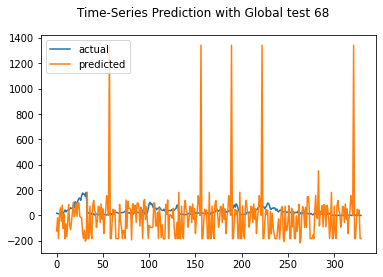

Test MAE: 87.358
Test RMSE: 186.999
Test sMAPE: 119.267
Test R Squared: -35.184
{'mae': 87.35801596208053, 'rmse': 186.9993988332993, 'smape': 119.2674493576514, 'r2': -35.1844872111591}


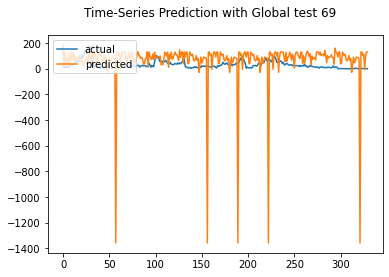

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 39.918
Test RMSE: 55.665
Test sMAPE: 104.395
Test R Squared: -2.206
{'mae': 39.9179193567146, 'rmse': 55.66473297562229, 'smape': 104.39532234643508, 'r2': -2.2062860231375905}


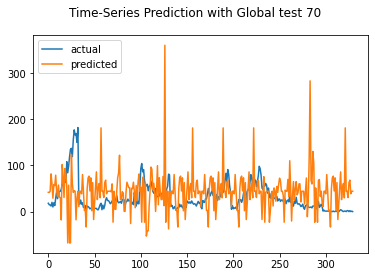

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 51.301
Test RMSE: 70.844
Test sMAPE: 109.529
Test R Squared: -4.193
{'mae': 51.30065799662561, 'rmse': 70.84411411963433, 'smape': 109.52865856714952, 'r2': -4.193373404871456}


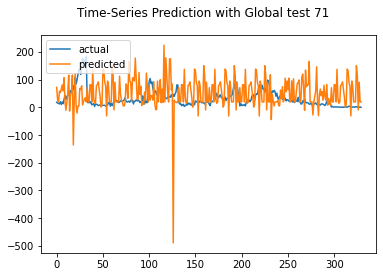

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 60.632
Test RMSE: 85.902
Test sMAPE: 132.968
Test R Squared: -6.636
{'mae': 60.63230420676145, 'rmse': 85.90225033408278, 'smape': 132.9680886336082, 'r2': -6.635739147276058}


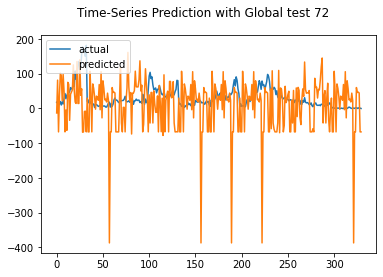

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 49.386
Test RMSE: 69.338
Test sMAPE: 110.040
Test R Squared: -3.975
{'mae': 49.38583267872984, 'rmse': 69.33809638662413, 'smape': 110.04017320146535, 'r2': -3.974916894832612}


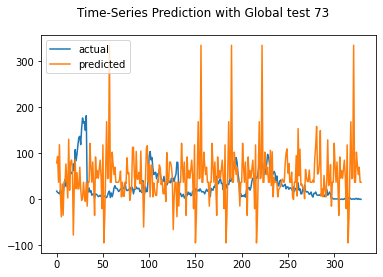

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 46.962
Test RMSE: 60.031
Test sMAPE: 128.091
Test R Squared: -2.729
{'mae': 46.962385308200666, 'rmse': 60.03139692070102, 'smape': 128.09052350348878, 'r2': -2.7290559590686114}


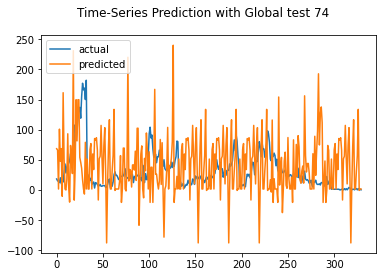

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 60.932
Test RMSE: 81.811
Test sMAPE: 121.892
Test R Squared: -5.926
{'mae': 60.93183134595553, 'rmse': 81.81104436455631, 'smape': 121.89233060212494, 'r2': -5.925735079832572}


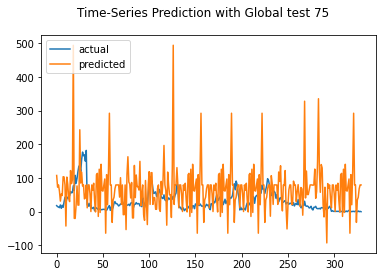

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 114.787
Test RMSE: 234.168
Test sMAPE: 159.821
Test R Squared: -55.741
{'mae': 114.78731603143792, 'rmse': 234.16754435273657, 'smape': 159.821366552448, 'r2': -55.740793499440514}


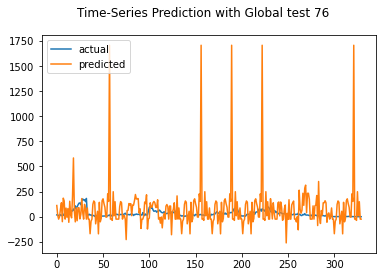

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 42.928
Test RMSE: 56.961
Test sMAPE: 121.977
Test R Squared: -2.357
{'mae': 42.92792429779515, 'rmse': 56.96090803828158, 'smape': 121.97736101733413, 'r2': -2.357343747950364}


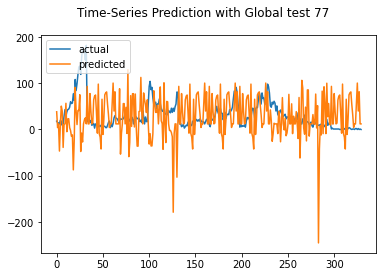

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 44.079
Test RMSE: 57.050
Test sMAPE: 101.344
Test R Squared: -2.368
{'mae': 44.07942498380488, 'rmse': 57.04960353424291, 'smape': 101.34387004481567, 'r2': -2.3678075246373025}


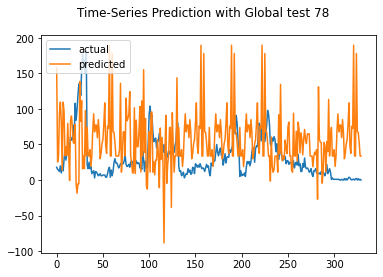

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 93.943
Test RMSE: 122.950
Test sMAPE: 133.819
Test R Squared: -14.642
{'mae': 93.94309581626545, 'rmse': 122.95045486140634, 'smape': 133.81878660941393, 'r2': -14.642360162119834}


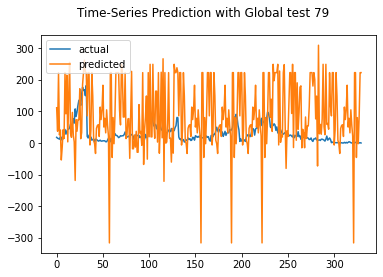

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 48.476
Test RMSE: 65.408
Test sMAPE: 128.549
Test R Squared: -3.427
{'mae': 48.475562442432754, 'rmse': 65.407892380554, 'smape': 128.54880462617714, 'r2': -3.4269265062882717}


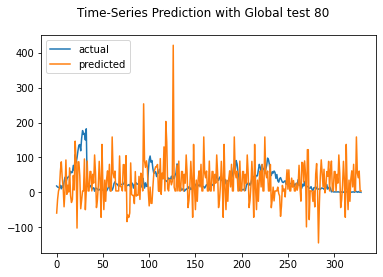

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 91.331
Test RMSE: 109.824
Test sMAPE: 139.219
Test R Squared: -11.481
{'mae': 91.33050269502581, 'rmse': 109.8236354241093, 'smape': 139.21856169608682, 'r2': -11.48054737759931}


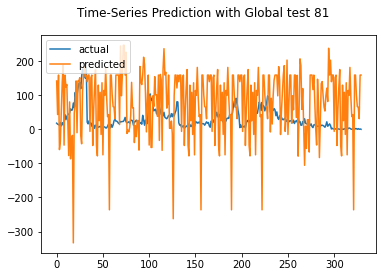

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.097
Test RMSE: 63.496
Test sMAPE: 138.417
Test R Squared: -3.172
{'mae': 45.096682266755536, 'rmse': 63.49595225624074, 'smape': 138.41696201225545, 'r2': -3.1719018565332764}


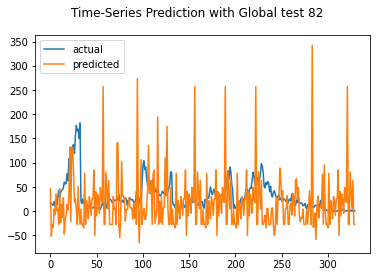

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 365.026
Test RMSE: 568.945
Test sMAPE: 198.281
Test R Squared: -333.952
{'mae': 365.0255311200113, 'rmse': 568.944860323639, 'smape': 198.28109558493867, 'r2': -333.9518328969006}


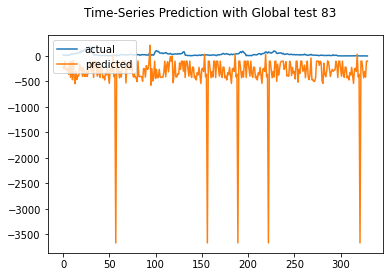

Test MAE: 103.109
Test RMSE: 277.581
Test sMAPE: 136.596
Test R Squared: -78.730
{'mae': 103.10878949237592, 'rmse': 277.58079901071875, 'smape': 136.59599629726256, 'r2': -78.72983122040952}


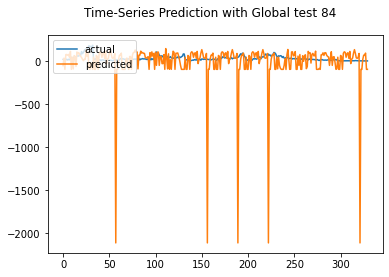

Test MAE: 132.610
Test RMSE: 430.715
Test sMAPE: 123.391
Test R Squared: -190.965
{'mae': 132.61025135697741, 'rmse': 430.7150492870056, 'smape': 123.39079140892497, 'r2': -190.9650182128094}


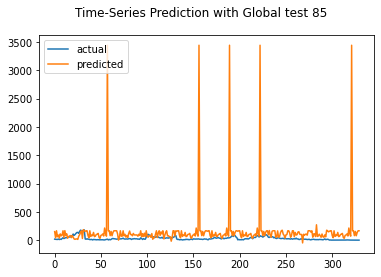

Test MAE: 120.477
Test RMSE: 157.243
Test sMAPE: 168.098
Test R Squared: -24.585
{'mae': 120.47743500272433, 'rmse': 157.2426559760976, 'smape': 168.09762242256045, 'r2': -24.584842238590642}


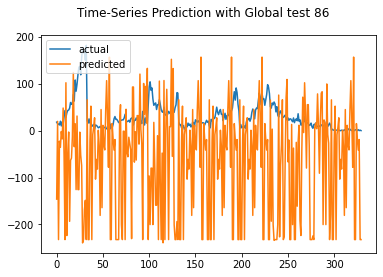

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 250.567
Test RMSE: 352.137
Test sMAPE: 176.435
Test R Squared: -127.312
{'mae': 250.5669982469443, 'rmse': 352.1374667025225, 'smape': 176.43548149483217, 'r2': -127.31176317426485}


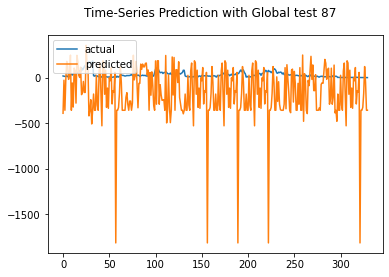

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 320.416
Test RMSE: 383.689
Test sMAPE: 175.701
Test R Squared: -151.336
{'mae': 320.41550186095816, 'rmse': 383.68943464189397, 'smape': 175.70094918629601, 'r2': -151.33569655808517}


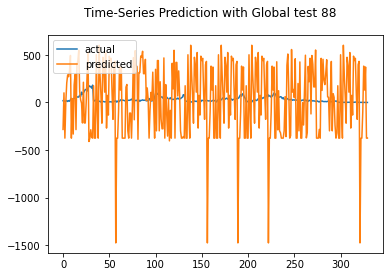

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 150.717
Test RMSE: 257.346
Test sMAPE: 167.344
Test R Squared: -67.529
{'mae': 150.71707804419776, 'rmse': 257.34560559153164, 'smape': 167.3439516943176, 'r2': -67.52917681476667}


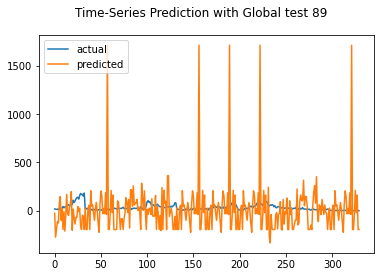

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 134.768
Test RMSE: 230.888
Test sMAPE: 141.966
Test R Squared: -54.162
{'mae': 134.76808260390254, 'rmse': 230.8876633950038, 'smape': 141.96639509902087, 'r2': -54.1624388457228}


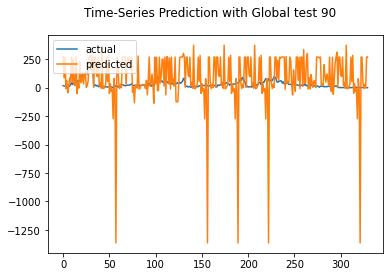

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 51.106
Test RMSE: 65.327
Test sMAPE: 114.251
Test R Squared: -3.416
{'mae': 51.10561500300061, 'rmse': 65.32701996452077, 'smape': 114.25136128087411, 'r2': -3.4159860861719666}


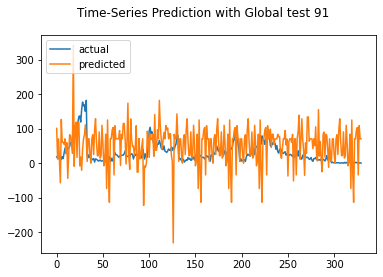

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 121.468
Test RMSE: 178.388
Test sMAPE: 158.539
Test R Squared: -31.928
{'mae': 121.46802049730763, 'rmse': 178.3875522134674, 'smape': 158.53931786747475, 'r2': -31.92843529110325}


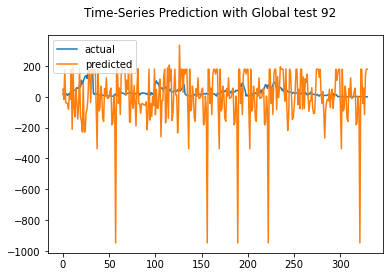

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 51.334
Test RMSE: 74.384
Test sMAPE: 115.491
Test R Squared: -4.725
{'mae': 51.33424464319692, 'rmse': 74.38375658767417, 'smape': 115.49120132043734, 'r2': -4.725299588474707}


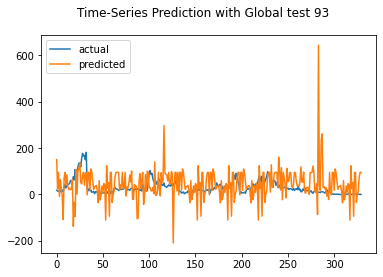

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 166.408
Test RMSE: 349.381
Test sMAPE: 150.267
Test R Squared: -125.311
{'mae': 166.40783383403763, 'rmse': 349.38069432695494, 'smape': 150.26704784885501, 'r2': -125.31060310481514}


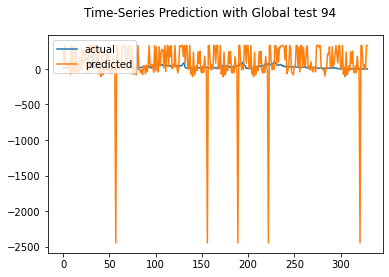

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 110.363
Test RMSE: 183.513
Test sMAPE: 151.335
Test R Squared: -33.848
{'mae': 110.36310922304789, 'rmse': 183.5132686117267, 'smape': 151.33535390002848, 'r2': -33.84792656946992}


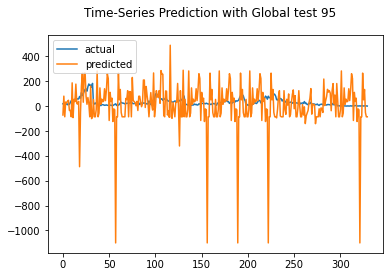

Test MAE: 81.429
Test RMSE: 193.825
Test sMAPE: 147.911
Test R Squared: -37.874
{'mae': 81.42944315635796, 'rmse': 193.82493971062908, 'smape': 147.91146765358442, 'r2': -37.874186759406534}


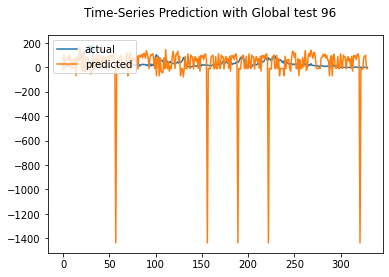

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 190.144
Test RMSE: 223.038
Test sMAPE: 176.854
Test R Squared: -50.476
{'mae': 190.14383177125092, 'rmse': 223.0382726755277, 'smape': 176.85423282657806, 'r2': -50.47552535905339}


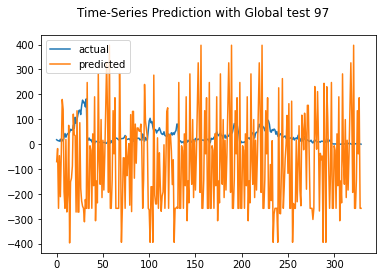

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 67.800
Test RMSE: 80.262
Test sMAPE: 126.598
Test R Squared: -5.666
{'mae': 67.80008754441232, 'rmse': 80.26202283971446, 'smape': 126.59787802250123, 'r2': -5.665952332443554}


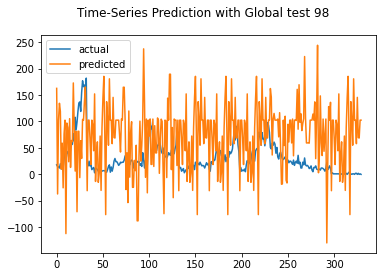

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 43.438
Test RMSE: 54.187
Test sMAPE: 122.547
Test R Squared: -2.038
{'mae': 43.43805442425338, 'rmse': 54.18692533738448, 'smape': 122.54698838608319, 'r2': -2.0383025617105823}


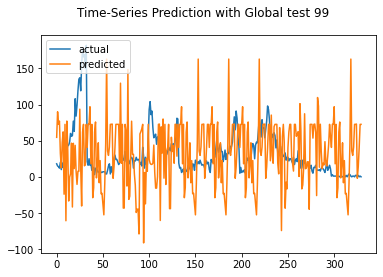

rmse : average=219.859, std=217.001
mae : average=123.014, std=80.342
smape : average=142.785, std=26.181
r2 : average=-97.745, std=373.323


([219.85853671257348, 217.00080361312175],
 [123.01392680232543, 80.34208874467812],
 [142.7853354549241, 26.18118888899386],
 [-97.74471054765947, 373.3228938966183])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')